In [1]:
# Google Drive mount
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
# import
import os
import matplotlib.pyplot as plt
import PIL
import PIL.Image
import tensorflow as tf
from matplotlib.image import imread
import cv2
import numpy as np

# VGG 전이학습 개요
content loss에서 VGG 네트워크의 feature map 중 conv4_4 feature map을 사용한다.

사전에 학습된 모델을 가져와서 사용하는 방법을 전이학습이라고 하는 데

그에 대해 공부하자.

- 참고 : https://antilibrary.org/1998

In [3]:
# 사전학습된 모델 불러오기
from keras.applications.vgg19 import VGG19

In [4]:
vgg_model = VGG19()

574717952/574710816 [==============================] - 5s 0us/step


In [5]:
vgg_model.summary()  # 모델의 요약정보 확인

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

# 우리가 필요한 VGG 네트워크의 conv4_4 feature map
block4_conv4 (Conv2D) 레이어의 feature map

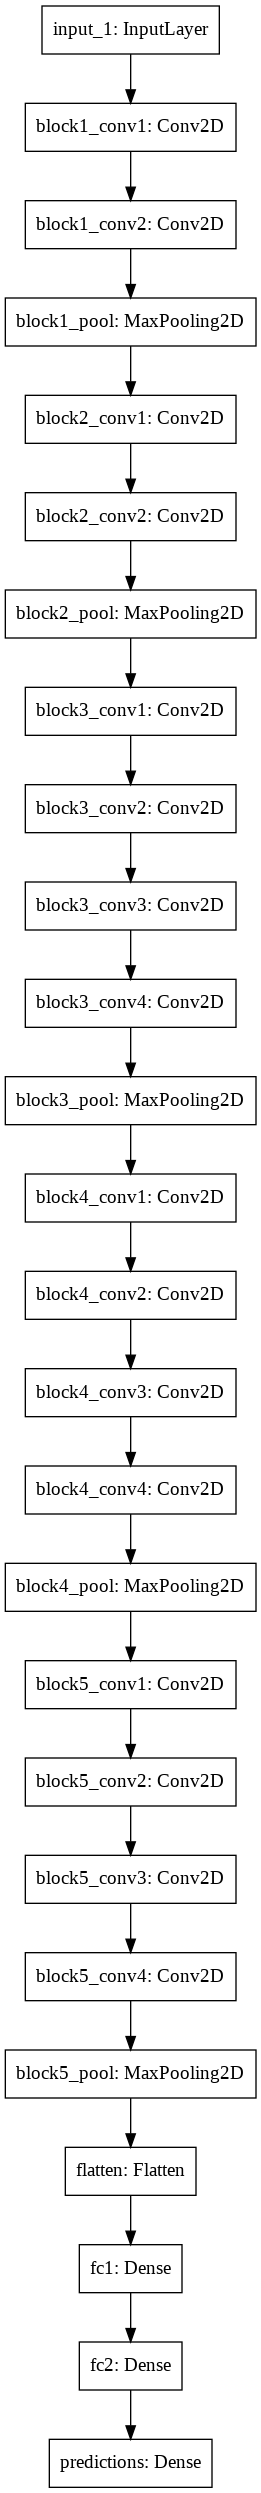

In [6]:
from keras.utils.vis_utils import plot_model
plot_model(vgg_model)

In [7]:
# 사진 불러오기
image_path = '/content/drive/MyDrive/GoogleColab/CartoonGAN_Project/data/photo_data'
imageName_list = os.listdir(image_path)
print(imageName_list)

['50817142731_dfc154ea75_o.jpg', '50819927577_2286b936e1_k.jpg', '50817727238_b7f3f5acd9_o.jpg', '50821206327_ea91c5e259_o.jpg', '50820323176_60016143b1_o.jpg', '40882481714_50b8a7490e_o.jpg', '44926777104_4ed4b51861_o.jpg', '27585811288_40d99dc08e_o.jpg', '5508784414_3ec3992ddc_o.jpg', '25690386427_7ef979d9ab_k.jpg', '46550224945_0933c0422d_o.jpg', '11950173946_12d060e602_o.jpg', '14000800067_3380375d17_o.jpg', '8389456987_92f2dc20b5_o.jpg', '27065384106_830d8f989f_o.jpg', '5442281059_acbbd90502_o.jpg', '40622326623_9bbfacb11f_o.jpg', '4093017926_2b6b9ee399_o.jpg', '6622944619_a8fc6d77e9_o.jpg', '15747627928_c20afa7264_o.jpg', '7607825946_b0e08b945e_o.jpg', '7485133934_8419a60df4_o.jpg', '26193799271_42602e946d_o.jpg', '26109514806_d1b6d09f05_o.jpg', '5402340884_6756056d7c_o.jpg', '3081555212_391ab6b09f_o.jpg', '32119532132_9d5c455538_o.jpg', '24734298297_7393230119_o.jpg', '27698876119_1a7e9bbf86_o.jpg', '32866901621_7ccd94bd65_o.jpg', '44257820692_b7997292a3_o.jpg', '3655024121_edd9

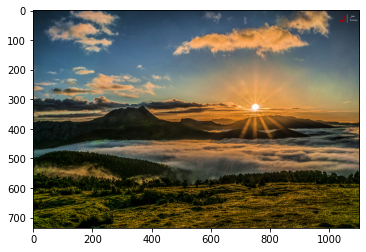

(735, 1102, 3)


In [8]:
# index=0인 사진 확인
img_bgr = cv2.imread(image_path + '/' + imageName_list[0])
img = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

print(img.shape)

In [9]:
def resizing(image_path):
  """
  ------------------------------------------------
  파라미터 설명

  img_path : resizing 해줄 이미지 디렉토리 위치
  resizing_path : resizing된 이미지를 저장할 디렉토리 위치
  ------------------------------------------------
  함수 설명

  resizing할 사이즈를 변경하려면 dsize=(300, 300) 부분을 바꾸면 된다.
  ------------------------------------------------
  """
  # 이미지 파일명을 담은 리스트 생성
  imageName_list = os.listdir(image_path)

  for imageName in imageName_list:
    img_bgr = cv2.imread(image_path + '/' + imageName_list[0])
    img = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    
    # 이미지 300x300 사이즈로 resizing
    img_resizing = cv2.resize(img, dsize=(300, 300), interpolation = cv2.INTER_LINEAR)
    
  return img_resizing

In [10]:
img_resizing = resizing(image_path)

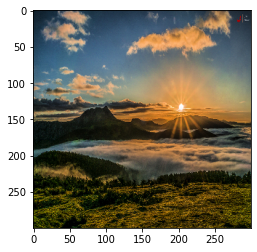

(300, 300, 3)


In [11]:
plt.imshow(img_resizing)
plt.show()

print(img_resizing.shape)

In [12]:
# keras로 작업하기 위해
# 이미지를 numpy array로 변경
img_array = np.asarray(img_resizing)

In [13]:
print(img_array.shape)

(300, 300, 3)


In [14]:
# VGG network는 1개 이상의 이미지를 입력으로 받는다.
# 즉, 입력배열이 4차원이어야 한다는 뜻이다.
# (samples, rows, columns, channels)가 shape가 되어야 한다.

# 지금은 우선 샘플로 이미지 1개만 갖고 하므로
# (1, 300, 300, 3)으로 바꿔주자.

img_2 = img_array.reshape((1, img_array.shape[0], img_array.shape[1], img_array.shape[2]))
print(img_2)
print(img_2.shape)

[[[[12 26 33]
   [13 27 35]
   [16 30 39]
   ...
   [24 34 42]
   [25 34 41]
   [28 37 46]]

  [[17 32 42]
   [13 30 40]
   [17 31 40]
   ...
   [27 36 45]
   [28 37 44]
   [25 34 43]]

  [[14 28 39]
   [14 28 40]
   [18 31 43]
   ...
   [27 36 46]
   [27 36 45]
   [26 36 44]]

  ...

  [[13 27  4]
   [51 46  1]
   [58 80  1]
   ...
   [37 52  7]
   [12 13  0]
   [18 14  1]]

  [[32 41  0]
   [ 4  7  1]
   [52 64  0]
   ...
   [ 5  2  0]
   [11 14  1]
   [ 5 15  6]]

  [[20 38  4]
   [35 51  0]
   [70 74  1]
   ...
   [61 63  2]
   [15 17  0]
   [60 52  0]]]]
(1, 300, 300, 3)


In [15]:
# shape를 보니 (1, 300, 300, 3)으로 shape가 잘 변경되었다.

In [16]:
# keras의 preprocess_input 메소드 사용
# 이유? 
# keras는 이미지 배치와 함께 작동한다. 따라서 (샘플(이미지)의 수, rows, columns, 채널의 수)로 작동하거나
# 이미지 1개일 때는 (rows, columns, 채널의 수)로 작동하는데
# 이 preprocess_input은 모델에 필요한 형식에 이미지를 적절하게 맞춰준다.

# 어떤 모델은 이미지를 0 ~ 1 범위의 값으로 받음
# 어떤 모델은 이미지를 -1 ~ 1 범위의 값으로 받음
# 이런 내부 정보를 걱정할 필요없이 preprocess_input 메소드가 다 해준다.
from keras.applications.vgg19 import preprocess_input
img_3 = preprocess_input(img_2)
print(img_3)
print(img_3.shape)

[[[[ -70.939     -90.779    -111.68    ]
   [ -68.939     -89.779    -110.68    ]
   [ -64.939     -86.779    -107.68    ]
   ...
   [ -61.939003  -82.779     -99.68    ]
   [ -62.939003  -82.779     -98.68    ]
   [ -57.939003  -79.779     -95.68    ]]

  [[ -61.939003  -84.779    -106.68    ]
   [ -63.939003  -86.779    -110.68    ]
   [ -63.939003  -85.779    -106.68    ]
   ...
   [ -58.939003  -80.779     -96.68    ]
   [ -59.939003  -79.779     -95.68    ]
   [ -60.939003  -82.779     -98.68    ]]

  [[ -64.939     -88.779    -109.68    ]
   [ -63.939003  -88.779    -109.68    ]
   [ -60.939003  -85.779    -105.68    ]
   ...
   [ -57.939003  -80.779     -96.68    ]
   [ -58.939003  -80.779     -96.68    ]
   [ -59.939003  -80.779     -97.68    ]]

  ...

  [[ -99.939     -89.779    -110.68    ]
   [-102.939     -70.779     -72.68    ]
   [-102.939     -36.779     -65.68    ]
   ...
   [ -96.939     -64.779     -86.68    ]
   [-103.939    -103.779    -111.68    ]
   [-102.939    

In [17]:
# VGG19의 input으로는 3차원의 배열을 받기 때문에
# keras의 preprocess_input 메소드가 알아서
# (300, 300, 3) -> (1, 300, 300, 3)으로 shape를 바꿔주었다

In [18]:
# y_hat = vgg_model.predict(img_3)
# print(y_hat)

In [19]:
# 에러가 났다.
# 에러 내용을 보니
# vgg19는 input shape로 (None, 224, 224, 3)이 들어와야 하는데
# 지금은 (None, 300, 300, 3)이 들어와서 에러가 났다고 한다.

In [20]:
# resizing을 원본 이미지에 대해 다시 해주자.
img_resizing2 = cv2.resize(img, dsize=(224, 224), interpolation = cv2.INTER_LINEAR)
print("img_resizing2의 shape", img_resizing2.shape)

# numpy array로 변경
img_array2 = np.asarray(img_resizing2)
print("img_array2의 shape", img_array2.shape)

# 4차원으로 변경
img_4 = img_array2.reshape((1, img_array2.shape[0], img_array2.shape[1], img_array2.shape[2]))
print("img_4의 shape", img_4.shape)

# preprocess_input 메소드 사용하여 VGG19에 맞는 input으로 설정
img_5 = preprocess_input(img_4)
print("img_5의 shape", img_5.shape)

img_resizing2의 shape (224, 224, 3)
img_array2의 shape (224, 224, 3)
img_4의 shape (1, 224, 224, 3)
img_5의 shape (1, 224, 224, 3)


In [21]:
img_4 == img_5

array([[[[False, False, False],
         [False, False, False],
         [False, False, False],
         ...,
         [False, False, False],
         [False, False, False],
         [False, False, False]],

        [[False, False, False],
         [False, False, False],
         [False, False, False],
         ...,
         [False, False, False],
         [False, False, False],
         [False, False, False]],

        [[False, False, False],
         [False, False, False],
         [False, False, False],
         ...,
         [False, False, False],
         [False, False, False],
         [False, False, False]],

        ...,

        [[False, False, False],
         [False, False, False],
         [False, False, False],
         ...,
         [False, False, False],
         [False, False, False],
         [False, False, False]],

        [[False, False, False],
         [False, False, False],
         [False, False, False],
         ...,
         [False, False, False],
         [Fa

In [22]:
# img_4와 img_5가 shape가 동일해서
# 동일한가 봤더니 동일하진 않다.

In [23]:
print(img_4)
print("---------------------------------------------")
print(img_5)

[[[[ 14  29  37]
   [ 17  29  41]
   [ 19  31  43]
   ...
   [ 25  34  43]
   [ 26  35  43]
   [ 29  38  47]]

  [[ 14  30  40]
   [ 15  30  39]
   [ 15  32  42]
   ...
   [ 28  36  46]
   [ 27  36  45]
   [ 27  36  45]]

  [[ 14  27  36]
   [ 17  32  43]
   [ 15  32  41]
   ...
   [ 29  37  47]
   [ 26  35  44]
   [ 25  35  44]]

  ...

  [[  5  10   1]
   [ 67  63   1]
   [  1   4   0]
   ...
   [ 87  97   0]
   [  1   3   0]
   [ 12  39   8]]

  [[ 13  30   1]
   [134 130   1]
   [ 28  41   0]
   ...
   [ 16  32   4]
   [  9  14   0]
   [  6   8   1]]

  [[ 31  36   2]
   [ 44  51   0]
   [ 55  90   0]
   ...
   [101  86   0]
   [ 96  90   0]
   [ 45  40   5]]]]
---------------------------------------------
[[[[ -66.939     -87.779    -109.68    ]
   [ -62.939003  -87.779    -106.68    ]
   [ -60.939003  -85.779    -104.68    ]
   ...
   [ -60.939003  -82.779     -98.68    ]
   [ -60.939003  -81.779     -97.68    ]
   [ -56.939003  -78.779     -94.68    ]]

  [[ -63.939003  -86.779 

In [24]:
# img_4는 원소가 정수인 반면에
# img_5는 원소가 소수이다.

In [25]:
# 예측
yhat = vgg_model.predict(img_5)
print(yhat)

[[2.37305045e-07 1.80126210e-06 2.64868532e-07 2.43623020e-07
  6.70869042e-07 4.76443830e-07 1.47033381e-06 5.05344360e-07
  1.76964903e-07 1.79806807e-06 2.55171841e-07 2.13380829e-07
  6.46246690e-07 3.57295562e-07 1.84166936e-07 1.12361204e-06
  1.97973584e-08 1.64480696e-07 4.50522884e-06 7.32570982e-08
  1.79908704e-06 1.28083207e-06 1.04361025e-05 1.02632494e-05
  1.65879527e-07 2.84024253e-07 1.76194149e-07 4.00492951e-07
  8.86214053e-08 1.29678881e-07 1.16241779e-06 4.67995349e-08
  7.49230793e-08 2.79867800e-06 4.86998288e-05 5.40188978e-07
  1.15682974e-06 5.25695825e-08 1.34439633e-08 7.91478612e-07
  5.02509678e-08 3.91472490e-08 3.25910690e-07 3.39077104e-07
  9.89150664e-08 1.50984272e-06 1.80615856e-07 6.23782839e-08
  2.63492154e-07 3.37992196e-06 1.86887773e-05 6.77372682e-08
  2.57584460e-08 1.55307291e-07 1.25185034e-06 4.70933692e-08
  9.44613276e-08 1.36082818e-07 7.25200789e-06 2.98071001e-07
  2.64981708e-07 8.96300634e-08 1.82165294e-07 1.24341142e-07
  1.2376

In [26]:
# 예측 해석
from keras.applications.vgg19 import decode_predictions

# keras는 decode_predictions라는 함수를 통해 확률을 해석한다.
# 결과물 : 확률이 가장 높은 상위 3개의 클래스와 확률을 출력
label = decode_predictions(yhat)
print(label)

40960/35363 [==================================] - 0s 0us/step
[[('n09472597', 'volcano', 0.27993232), ('n09428293', 'seashore', 0.2387313), ('n09332890', 'lakeside', 0.15977496), ('n09468604', 'valley', 0.08483132), ('n02814860', 'beacon', 0.051904295)]]


In [27]:
label = label[0][0]
print("%s (%.2f%%)" %(label[1], label[2]*100))

volcano (27.99%)


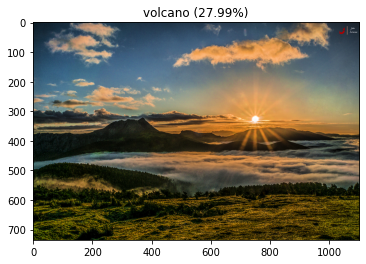

In [28]:
plt.imshow(img)
plt.title("%s (%.2f%%)" %(label[1], label[2]*100))
plt.show()

In [29]:
# 27.99%의 확률로 화산이라고 예측했다.

In [30]:
# 이런식으로 미리 사전학습된 모델(여기서는 VGG19모델)을 사용하여 전이학습을 하는 것인데
# 이 중에서 conv4_4 layer의 feature map이 필요하다.

# keras의 function 함수를 사용하면
# 입력값에서 특정 layer의 출력을 계산해주는 함수를 만들 수 있다.

In [31]:
# 먼저 layer의 순서를 확인해보자.
vgg_model.layers

In [32]:
from keras.layers import Input
from keras.models import Model

input_shape1 = (224, 224, 3)
input_layer1 = Input(shape = input_shape1)
net1 = vgg_model.layers[0](input_layer1)
net1 = vgg_model.layers[1](net1)
net1 = vgg_model.layers[2](net1)
net1 = vgg_model.layers[3](net1)
net1 = vgg_model.layers[4](net1)
net1 = vgg_model.layers[5](net1)
net1 = vgg_model.layers[6](net1)
net1 = vgg_model.layers[7](net1)
net1 = vgg_model.layers[8](net1)
net1 = vgg_model.layers[9](net1)
net1 = vgg_model.layers[10](net1)
net1 = vgg_model.layers[11](net1)
net1 = vgg_model.layers[12](net1)
net1 = vgg_model.layers[13](net1)
net1 = vgg_model.layers[14](net1)
net1 = vgg_model.layers[15](net1)

model1 = Model(inputs = input_layer1,
               outputs = net1,
               name = "vgg_layer_0to15")
model1.summary()

Model: "vgg_layer_0to15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
input_1 (InputLayer)         multiple                  0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128) 

In [33]:
# img_5 사진을 tensorflow 배열로 만들자.
img_6 = tf.cast(img_5, dtype = tf.float32)
print(img_6.shape)
print(img_6.dtype)

(1, 224, 224, 3)
<dtype: 'float32'>


In [34]:
# conv4_4 feature map을 꺼내기 위해서
# vgg19의 index 0 ~ 15번째까지의 모델 따로 만든 것에(model1 변수)
# img_6을 대입하자.

vgg_conv4_4_output = model1(img_6)
print(vgg_conv4_4_output.shape)

(1, 28, 28, 512)


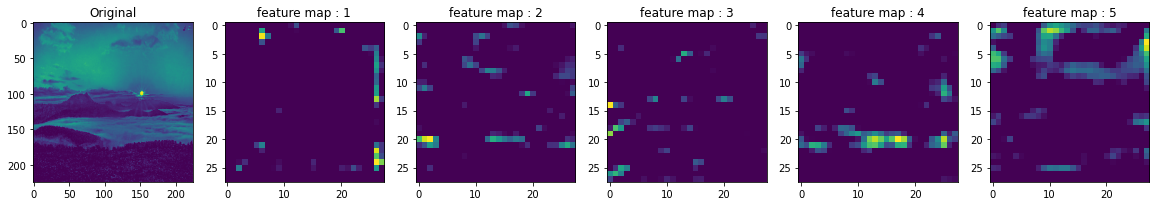

In [35]:
# conv4_4 feature map을 시각화해보자.
_, axes = plt.subplots(nrows=1, ncols=6, figsize=(20, 10))
axes[0].imshow(img_6[0, ..., 0])
axes[0].set_title("Original")

for idx, ax in enumerate(axes[1:]):
  ax.set_title("feature map : {}".format(idx + 1))
  ax.imshow(vgg_conv4_4_output[0, ..., idx])
plt.show()

# conv4_4 feature map에 l1 규제
- Conv4_4 feature map에 l1 규제를 취하는 방법은
- keras의 regularizer를 이용하면 된다.
- regularizer는 최적화 과정 중에 각 층별 파라미터 또는 출력값에 대하여 패널티를 적용할 수 있게 해준다. 이러한 패널티는 네트워크가 최적화하려는 손실 함수의 일부로 포함된다.
- Dense, Conv1D, Conv2D, Conv3D는 동일한 API를 가지고 있다.
- 파라미터 설명
  - kernel_regularizer
  - bias_regularizer
  - activity_regularizer
- 사용 예제
```python
from keras import regularizers
model.add(Dense(64, input_dim = 64,
                kernel_regularizer = regularizers.l2(0.01),
                activity_regularizer = regularizers.l1(0.01)))
```
- 사용가능한 패널티
```python
keras.regularizersl1(0.)
keras.regularizers.l2(0.)
keras.regularizers.l1_l2(l1 = 0.01, l2 = 0.01)
```
- 참고 : https://keras.io/ko/regularizers/

In [36]:
# 원본 사진, 카툰화된 이미지를 받아서
# conv4_4 feature map으로 통과 시킨 후
# l1 규제를 취해준다.
# 그러면 맨 마지막 layer인 conv4_4 layer에 l1 규제를 파라미터로 추가시켜서
# 새로운 모델을 만들자.

In [37]:
# 모델을 이전처럼 keras의 layers를 이용해서 가져오게 되면 하이퍼파라미터를 추가할 수 없다.
# 따라서, 가중치를 피클로 가져와서 하이퍼파라미터 regularizers.l1을 추가하는 방식으로 하자.

In [38]:
# 다른 분들이 모델링해서 github에 올린 코드들을 보면
# MAE(mean absolute error)를 사용해서 구했다.
# MAE는 예측값, 정답의 차이의 절댓값을 취해서
# 모두 더한 후
# 갯수로 나눠서 평균을 낸것이다.
# 따라서 l1 규제와 비슷하게 사용할 수 있기 때문에 MAE를 사용한 것으로 보인다.

# 나는 MAE를 사용하지 않고 l1 regularizer를 직접 구현하여 구하겠다.

# l1 규제 공식
- <img src="https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=http%3A%2F%2Fcfile7.uf.tistory.com%2Fimage%2F990905425CE4AE6B1284A7" width=300>

In [47]:
from keras.losses import BinaryCrossentropy
def l1_regularizer(original_conv4_4_feature_map, cartoonized_conv4_4_feature_map):
  """
  -------------------------------------------------
  하이퍼파라미터 설명
  -------------------------------------------------
  original_conv4_4_feature_map : 원본 사진이 VGG19 모델의 conv4_4 레이어를 통과하여
                                 얻어진 feature map
  cartoonized_conv4_4_feature_map : 카툰화된 사진이 VGG19 모델의 conv4_4 레이어를 통과하여
                                    얻어진 feature map
  -------------------------------------------------
  함수 설명
  -------------------------------------------------
  기존의 cost function : binary cross entropy
  람다값은 0이상의 값
  모델이 훈련할 때 loss값을 최소화하는 방향으로 가중치가 학습되는 데
  람다/2*|w| 항은 상수값이므로 영향을 미치지 않는다.
  0으로 놓고 구하겠다.
  -------------------------------------------------
  """

  n = vgg_conv4_4_output.shape[-1]
  bce = keras.losses.BinaryCrossentropy()
  error = bce(original_conv4_4_feature_map, cartoonized_conv4_4_feature_map).numpy()
  
  return error